# Ab-initio synthesis of Amino Acids

### Project Contributors: Sahana G (BE17B038) and Sowmya Manojna (BE17B007)

### Abstract

About seventy years ago, Stanley L. Miller and Harold C. Urey demonstrated the first evidence for the prebiotic synthesis of life. Their path-breaking experiment simulated conditions that are very similar to primitive Earth - atmosphere consisting of highly reducing gas mixture such as methane, ammonia and carbon dioxide, water as the solvent and high electric current discharges accounting for lightning. Upon testing the prebiotic “soup” for the presence of organic compounds, several amino acids were found. The main objective of our study is to perform in-silico simulations, similar to the Urey-Miller experiment to study the formation of amino acids. 

A network biology approach, where nodes represent elements, edges represent the covalent bonds connecting these elements and connected components represent compounds, is adopted for this study. The number of edges that each node can have, is constrained by the valency of the element. The edge weights depict the Gibbs free energy variation between the initial compound to the final compound. The simulated annealing approach would be used to scan the reaction space in our approach.


In [1]:
# Import all essential libraries

import os
import csv
# import ipdb
import math
import warnings
import random
import numpy as np
import networkx as nx
import scipy.constants as sc
import matplotlib.pyplot as plt
import networkx.algorithms.isomorphism as iso
# %matplotlib qt
from IPython.core.debugger import Pdb
ipdb = Pdb()

In [2]:
#Function for plotting a MultiGraph

def plot_fig(G, title=""):
    A = nx.adjacency_matrix(G)
    pos = nx.spring_layout(G) #Using spring layout for the edges
    nodes = list(nx.nodes(G))
    mapping = {}
    for i,j in enumerate(nodes):
        mapping[j] = i
        
    plt.figure()
    if title: plt.title(title)
    
    # Edge labels represent the number of bonds between any two nodes(atoms)
    for i in G.edges():
        G[i[0]][i[1]][0]['number'] = A[mapping[i[0]], mapping[i[1]]]
    labels = nx.get_edge_attributes(G, 'number')
    edge_labels = {}
    for i in labels:
        edge_labels[(i[0], i[1])] = labels[i]
    nx.draw(G, pos, with_labels=True,edge_color='black',width=1,linewidths=1,node_size = 500,node_color='pink',alpha=0.9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
    # plt.axis('off')
    plt.show()

In [3]:
#Class for representing each atom/element in the network. Atoms are represented by nodes

class Compound():
    def __init__(self, name, number):
        self._name = name + " " + str(number)
        self._number = number
        self._valency = self.get_max_valency()
    
    #Function for alloting the maximum valency for each compound. 
    def get_max_valency(self):
        name = self._name.split()[0]
        if name == "H":
            return 1
        elif name == "C":
            return 4
        elif name == "N":
            return 3
        elif name == "O":
            return 2
        elif name == "S":
            return 2
    
    #Function for updateing valency of an atom based on its connections/degree.
    def current_valency(self, G):
        neig = nx.degree(G, self)
        max_val = self.get_max_valency()
        if neig > max_val:
            ipdb.set_trace()
            raise ValueError('Compound has more neighbours than valence')
        else:
            # print(max_val, neig)
            self._valency = max_val - neig
    
    #Function to return the valency of the atom at any state.
    def get_total_valency(self, G):
        neig = nx.degree(G, self)
        free_electrons = self.get_max_valency() - neig
        return free_electrons
        
    #The atom is represented by "X i" where X: chemical symbol for the element and i: label.    
    def __repr__(self):
        return self._name

In [4]:
# Defining the atom list in the Graph

H_list = [Compound("H", i) for i in range(1,33)]
C_list = [Compound("C", i) for i in range(33, 41)]
O_list = [Compound("O", i) for i in range(41, 49)]
N_list = [Compound("N", i) for i in range(49, 57)]

complete_list = [];
for lst in [H_list, C_list, O_list, N_list]:
    complete_list.extend(lst)

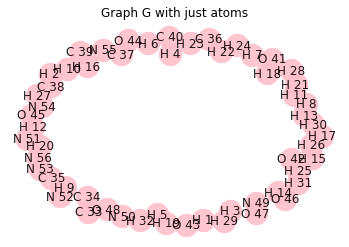

In [5]:
# Creating the graph with just atoms
# MultiGraph is being used for ease of representing
# double and possible triple bonds
# Here, 
#    - lst loops through the lists (H, C, O and N)
#    - comp loops over the compounds

G = nx.MultiGraph()
for i,lst in enumerate([H_list, C_list, O_list, N_list]):
    for comp in lst:
        G.add_node(comp, data=comp)
plot_fig(G, "Graph G with just atoms")

In [6]:
# Function to update the valencies of the atoms
# This function updates the atom valencies based 
# on the number of edges that atom forms.

def fix_valencies(G):
    for node in nx.nodes(G):
        degree = len(G[node])
        if degree > 0:
            node.current_valency(G)

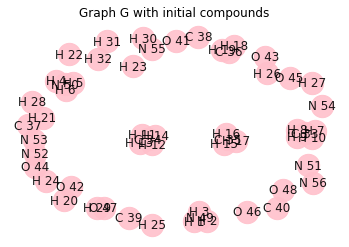

In [7]:
# Adding all the nodes

G.add_edges_from([(H_list[0], N_list[0]), (N_list[0], H_list[1]), (N_list[0], H_list[2])])
G.add_edges_from([(H_list[3], N_list[1]), (N_list[1], H_list[4]), (N_list[1], H_list[5])])

G.add_edges_from([(H_list[6], C_list[0]), (H_list[7], C_list[0]), (H_list[8], C_list[0]), (H_list[9], C_list[0])])
G.add_edges_from([(H_list[10], C_list[1]), (H_list[11], C_list[1]), (H_list[12], C_list[1]), (H_list[13], C_list[1])])

#Added CH3, CH2 and OH to test bond formations. 
G.add_edges_from([(H_list[14], C_list[2]), (H_list[15], C_list[2]), (H_list[16], C_list[2])])
G.add_edges_from([(H_list[17], C_list[3]), (H_list[18], C_list[3])])
G.add_edge(O_list[6], H_list[28])

fix_valencies(G)
plot_fig(G, "Graph G with initial compounds")

In [8]:
# Function to calculate H

def calculate_H(data, T):
    [a_2, a_1, a0, a1, a2, a3, a4, a5, _] = data

    H = sc.R*T*(-a_2*T**-2 + a_1*T**-1*np.log(T) + a0 + 0.5*a1*T + (a2*T**2)/3 + 0.25*a3*T**3 + 0.2*a4*T**4 +a5*T**-1)
    return H

# Function to calculate S

def calculate_S(data, T):
    [a_2, a_1, a0, a1, a2, a3, a4, _, a6] = data

    S = sc.R*(-0.5*a_2*T**-2 - a_1*T**-1 + a0*np.log(T) + a1*T + 0.5*a2*T**2 + (a3*T**3/3) + 0.25*a4*T**4 + a6)

    return S

# Function to calculate G

def calculate_G(H, S, T):
    G = H - T*S
    return G

In [9]:
#Updates the number of free electrons for each atom in the network.

free_electrons = []
for i in complete_list:
    val = 0
    compound_contrib = {}
    if np.size(i) > 1:
        for j in i:
            compound_contrib[j] = j.get_total_valency(G)
            val += j.get_total_valency(G)
    else:
        compound_contrib[i] = i.get_total_valency(G)
        val += i.get_total_valency(G)
    free_electrons.append((val, compound_contrib))

In [10]:
#Calculates the maximum number of bonds possible by summing up the valency of all the atoms present in the network. 

maximum_edges = 0; # 52
for lst in [H_list, C_list, O_list, N_list]:
    for atom in lst:
        maximum_edges += atom.get_max_valency()
        
maximum_edges = maximum_edges//2;
print("The maximum number of edges in G graph:", maximum_edges)

The maximum number of edges in G graph: 52


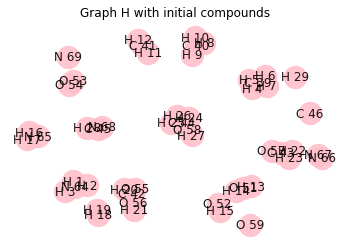

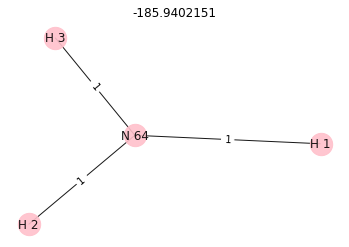

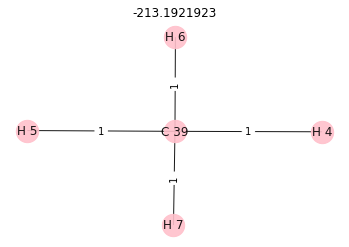

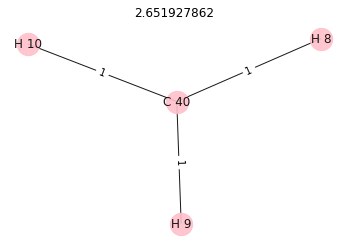

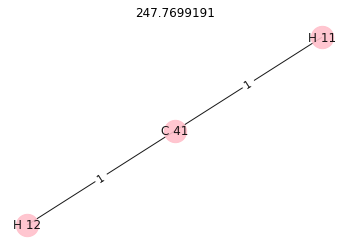

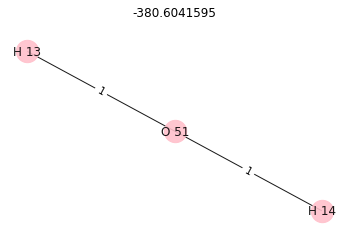

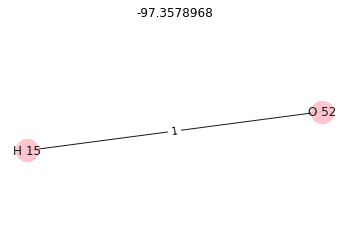

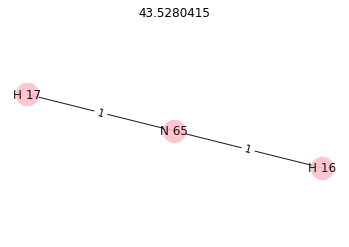

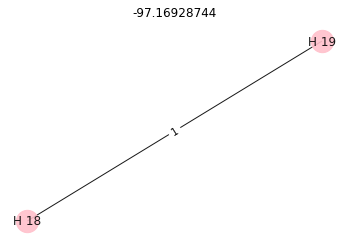

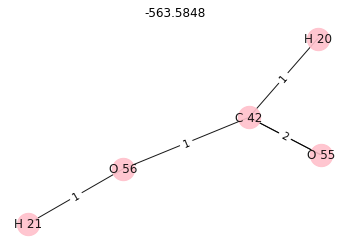

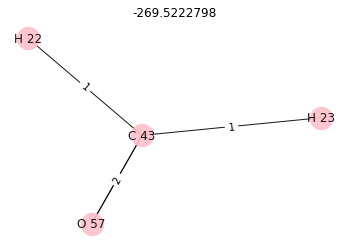

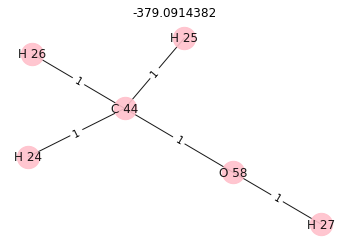

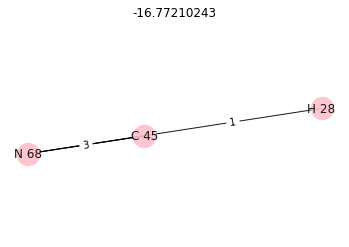

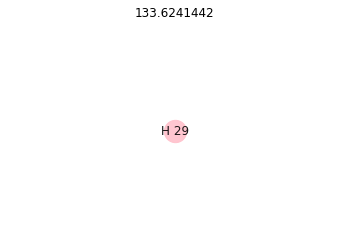

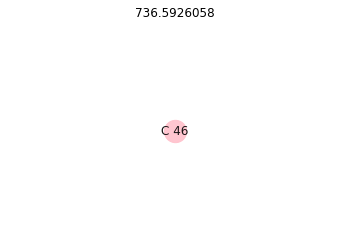

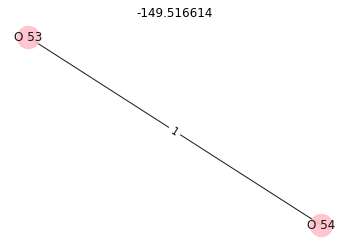

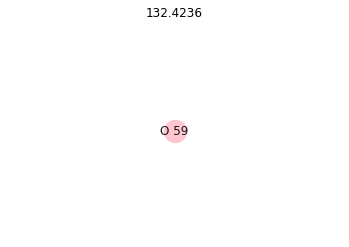

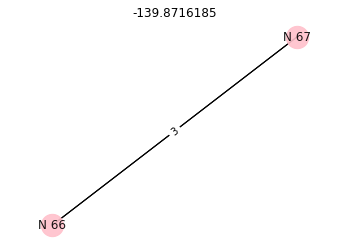

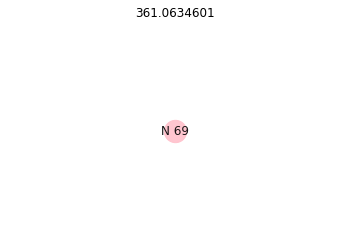

In [11]:
#This graph acts like a database. It stores known intermediates from literature as connected components in them. 
#The dictionary data_G links these components to their corresponding free energy values.
H = nx.MultiGraph()

H_lists = [Compound("H",i) for i in range(1,30)]
C_lists = [Compound("C",i) for i in range(39, 47)]
O_lists = [Compound("O",i) for i in range(51, 60)]
N_lists = [Compound("N",i) for i in range(64, 70)]
for i,lst in enumerate([H_lists, C_lists, O_lists, N_lists]):
    for comp in lst:
        H.add_node(comp, data=comp)

# nx.draw(H,with_labels=True)
H.add_edges_from([(H_lists[0], N_lists[0]), (N_lists[0], H_lists[1]), (N_lists[0], H_lists[2])])
H.add_edges_from([(H_lists[3], C_lists[0]), (H_lists[4], C_lists[0]), (H_lists[5], C_lists[0]), (H_lists[6], C_lists[0])])
H.add_edges_from([(H_lists[7], C_lists[1]), (H_lists[8], C_lists[1]), (H_lists[9], C_lists[1])])
H.add_edges_from([(H_lists[10], C_lists[2]), (H_lists[11], C_lists[2])])
H.add_edges_from([(H_lists[12], O_lists[0]), (H_lists[13], O_lists[0])])
H.add_edges_from([(H_lists[14], O_lists[1])])
H.add_edges_from([(H_lists[15], N_lists[1]), (N_lists[1], H_lists[16])])
H.add_edges_from([(H_lists[17], H_lists[18])])
H.add_edges_from([(O_lists[2], O_lists[3])])
H.add_edges_from([(N_lists[2], N_lists[3]), (N_lists[2], N_lists[3]), (N_lists[2], N_lists[3])])
H.add_edges_from([(H_lists[19], C_lists[3]),(O_lists[4], C_lists[3]),(O_lists[4], C_lists[3]),(O_lists[5], C_lists[3]),(H_lists[20], O_lists[5])])
H.add_edges_from([(H_lists[21], C_lists[4]),(O_lists[6], C_lists[4]),(O_lists[6], C_lists[4]),(H_lists[22], C_lists[4])])
H.add_edges_from([(H_lists[23], C_lists[5]), (H_lists[24], C_lists[5]), (H_lists[25], C_lists[5]),(O_lists[7], C_lists[5]),(O_lists[7], H_lists[26])])
H.add_edges_from([(H_lists[27], C_lists[6]), (N_lists[4], C_lists[6]), (N_lists[4], C_lists[6]), (N_lists[4], C_lists[6])])

plot_fig(H, "Graph H with initial compounds")

data_G = {}
#Gibbs free energy value for the connected compounds.
G_value = [-185.9402151,-213.1921923,2.651927862,247.7699191,-380.6041595,-97.3578968,43.5280415,-97.16928744,-563.5848,-269.5222798,-379.0914382,-16.77210243,133.6241442,736.5926058,-149.516614,132.4236,-139.8716185,361.0634601]

#Each connected component in the network H is an expected key intermediate from our model. 
#These compounds are now matched to their G value using a dictionary.
entities = nx.connected_components(H)
entities = list(entities)

for i in range(len(entities)):
    sub = H.subgraph(list(entities[i]))
    data_G[sub] = G_value[i]
    plot_fig(sub, G_value[i])
    
#The valency of all atoms in H is now updated.    
fix_valencies(H)    

In [12]:
# for i in G.nodes:
#     i.current_valency(G)

In [13]:
# Finding G of all components given a network
# Input 
#     - G: the network whose total gibbs free energy needs to be calculated
# Output
#     - G_energy: gibbs free energy of the network

def input_G(G):
    
    #All the connected components of the network is obtained
    cc = list(nx.connected_components(G))
    G_energy = 0
    
    for i in range(len(cc)):
        found = 0
        # Fetch a connected component and check if it is isomorphic to any of the subgraphs in the database network H.
        # Variable 'same' and 'found' keeps track of whether a compound in matched to the ones on the database.
        sub_G = G.subgraph(list(cc[i]))
        same = False
        
        for j in data_G:
            
            # iso.is_isomorphic compared the connection of nodes between two graphs.
            GH = iso.GraphMatcher(sub_G,j)
            if GH.is_isomorphic() == True:
                same = True
            else:
                same = False
            # In case a network with the same connections as our compound is found, 
            #we check the mapping for each nodes' label to confirm the same.
            if same == True:
                if len(GH.mapping) != 2:
                    for k in GH.mapping: # check mapping of each nodes
                        if str(k)[0] == str(GH.mapping[k])[0]: # Each node's label (without index) should coincide
                            same = True
                        else:
                            same = False
                            break
                else:
                    keys = []
                    values = []
                    for i in GH.mapping.keys():
                        keys.append(str(i).split()[0])
                    for i in GH.mapping.keys():
                        values.append(str(i).split()[0])
                    keys = keys.sort()
                    values = values.sort()
                    if keys == values:
                        same = True
                    else: 
                        same = False
    
            if same == True: # If compound is found, add G
                found = 1
                break

        if same == True:
            G_energy += data_G[j]
            
        elif same == False: # If compound not found,
            randomp = G.subgraph(list(cc[i]))
            plot_fig(randomp)
            
            val = float(input('Enter G value of %s: '%list(cc[i])))
            data_G[sub_G] = val # Add the new compound's data to our dictionary
            G_energy += val

    return G_energy

In [14]:
def get_exp_number_bonds(s, max_bonds):
    # Function imitates a Michaelis-Menten curve
    # for the number of bonds allowable at a 
    # given cycle and ceils the value returned.
    bond = math.ceil((max_bonds*s)/(0.5 + s))
    
    return bond

In [15]:
#Function to obtain an electrically neutral compound, incase valencies are not satisfied.
# Input -
#     - G: the network that needs to be modified
# Output -
#     - G_new: the modified network
def get_neutral_compound(G):
    G_new = G.copy() #shall-copying, so that the main graph is not affected in every turn.
    
    #Obtain the connected components in a network
    connected_components = list(nx.connected_components(G_new))
    
    #Update valency for each node in the new network
    for i in nx.nodes(G_new): 
        i.current_valency(G_new)
    
    single_nodes = [list(i) for i in connected_components if len(i) == 1]
    
    for cc in connected_components:
        if len(cc) > 1: #for compounds comprising of more than 1 atom
            
            M = G_new.subgraph(list(cc))
            for node in nx.nodes(M): #Calculate the total unsatisfied valency of neighbouring atoms for a chosen node.
                neigh_sum = 0
                if node._valency != 0: 
                    neigh_valencies = [(i._valency, i) for i in nx.neighbors(G_new,node)] 
                    for i in neigh_valencies: neigh_sum += i[0]
                    
                    #If atoms in the same compound have unsatisfied valency, form bonds between them
                    if len(neigh_valencies)>0: 
                        possible_neigh = [(i,x[0],x[1]) for i,x in enumerate(neigh_valencies) if x[0]>0]
                        if len(possible_neigh) > 1:
                            pos = random.randint(0, len(possible_neigh)-1)
                            for i in range(min(node._valency, possible_neigh[pos][1])):
                                G_new.add_edge(node, possible_neigh[pos][2])
                        elif len(possible_neigh)==1:
                            pos = 0
                            G_new.add_edge(node, possible_neigh[pos][2])
                    
                    #If no such neighbour (with free electrons) exist, find free Hydrogen atoms in the network and form bond appropriately.
                    if (neigh_sum == 0):
                        noof_H = 0
                        H_nodes = []
                        
                        #Finding number of free hydrogen atoms in the network
                        for i in single_nodes:
                            if i[0]._name.split()[0] == "H":
                                H_nodes.append(i[0])
                                noof_H += 1
                        # If the number of free electrons that needs to be balanced is less than the available H atoms, 
                        # form bonds within the network. Else create H atoms and form bonds appropriately       
                        if node._valency <= noof_H:
                            for i in range(node._valency):
                                G_new.add_edge(node, H_nodes[i])
                        else: 
                            N = len(nx.nodes(G_new))
                            for i in range(node._valency):
                                G_new.add_node(Compound("H", i+N))
                                G_new.add_edge(node, Compound("H", i+N))
                    
                    single_nodes = [list(i) for i in nx.connected_components(G_new) if len(i)==1]
                
                #Update valency of all nodes in the network
                for i in nx.nodes(G_new):
                    i.current_valency(G_new)
    return G_new

In [16]:
# generate_random_graphs picks two random nodes in the graph and forms a bond between them, 
# while ensuring that valencies are satisfied.
# Input -
#     - G: the network that needs to be modified
#     - max_bonds: the maximum number of edges that can be accomodated in the network
#     - probab - the number of bonds allowable in a given cycle
#     - max_size - the half of maximum size of a connected component that forms after addition of an edge.
# Output -
#     - G_new: the modified network

def generate_random_graphs(G, max_bonds, probab, max_size):
    G_new = G.copy()
    nodes = []
    
    #Fetch compounds whose size is less than max_size
    for i in nx.connected_components(G_new):
        if len(i) < max_size:
            nodes.extend(list(i))
    
    valency_incomplete_nodes = [i for i in nx.nodes(G_new) if i._valency!=0]

    connected_components = nx.connected_components(G_new)
    
    num_executed = 0
    bonds = get_exp_number_bonds(probab, max_bonds)
    # print("Bonds to be formed:", bonds)
    # print("Number of edges:", nx.number_of_edges(G_new))
    if bonds > max_bonds:
        bonds = 0
    
    # While new bonds can be formed, based on the said criteria.
    while (nx.number_of_edges(G_new) < bonds) and (len(nodes)>1) and (len(valency_incomplete_nodes) > 1):
        print("Nodes:", nodes)
        num_executed += 1
        # ipdb.set_trace()
        # print("Bonds to be formed:", bonds)
        # print("Number of edges:", nx.number_of_edges(G_new))
        flag = 0
        initial_net = G_new
        row = random.randint(0,len(nodes)-1) #Pick a node and find its valency
        cur_val1 = (nodes[row])._valency
        # ipdb.set_trace()
        while not(cur_val1 >= 1): #If there are no free electrons available in the node, pick a node again.
            flag = 1
            row = random.randint(0,len(nodes)-1)
            cur_val1 = nodes[row]._valency
        else:
            print("Row:", row)
            print("Node1:", nodes[row]._name)
            print("Curr val1:", cur_val1)
            
            #Pick a seconds node in a similar fashion and ensure that both the nodes are different
            col = random.randint(0, len(nodes)-1) 
            cur_val2 = nodes[col]._valency
            while (not(cur_val2 >= 1)) or (row==col):
                flag = 2
                col = random.randint(0, len(nodes)-1)
                cur_val2 = nodes[col]._valency
                
                print("Random node choosen:", nodes[col]._name, "; Valency:", nodes[col]._valency)
                
                #If valency conditions are emt, form an edge
                if cur_val2 > 0 and (row!=col):
                    max_num_edges = random.randint(1, min(nodes[row]._valency, nodes[col]._valency))
                    print("Col:", col)
                    print("Node2:", nodes[col]._name)
                    print("Curr val2:", cur_val2)
                    print(nodes[row]._valency, nodes[col]._valency)
                    print("max_num_edges:", max_num_edges)
                            
                    for times in range(max_num_edges):
                        G_new.add_edge(nodes[row], nodes[col])
            
            # Pruning any self edges
            for i in range(len(nodes)):
                neigh = G_new[nodes[i]]
                while nodes[i] in neigh:
                    G_new.remove_edge(nodes[i], nodes[i])
                
            # print("flag_end:", flag)
            
            # Maximum number of edges that can be formed without disturbing valency is identified and created.
            if flag == 0 and (row!= col):
                if min(nodes[row]._valency, nodes[col]._valency) > 1:
                    max_num_edges = random.randint(1, min(nodes[row]._valency, nodes[col]._valency))
                else: max_num_edges = 1
                for times in range(max_num_edges):
                    G_new.add_edge(nodes[row], nodes[col])
        
        #Plotting the final graph
        plot_fig(G_new)
        
        #Update valency of all the nodes in the modified network
        for i in list(nx.nodes(G_new)):
            # if (i==nodes[row]) or (i==nodes[col]): 
            #     print(i._name, "Previous Valency:", i._valency)
            try:
                i.current_valency(G_new)
            except ValueError:
                print("ValueException occured!!!")
                # print(i._name)
                # print(i._valency)
                ipdb.set_trace()
                for cc in nx.connected_components(G_new):
                    if nodes[row] in cc:
                        plot_fig(G_new.subgraph(list(cc)))
            # if (i==nodes[row]) or (i==nodes[col]): 
            #     print(i._name, "Current valency:", i._valency)
                
        nodes = []
        for i in nx.connected_components(G_new):
            if len(i) < max_size:
                nodes.extend(list(i))
        
    print("Executed:", num_executed) # to keep track of the number of rounds that were executed within the while loop
    # plot_fig(G_new)
    
    # Make the modified graph electrically neutral by charge.
    G_new = get_neutral_compound(G_new)
    
    return G_new

In [17]:
def rearrange_connected_components(G, cc, n, times):
    for i in range(times):
        comp1_idx = random.randint(0,n-1)
        comp2_idx = random.randint(0,n-1)
        comp1 = G.subgraph(list(cc[comp1_idx]))
        comp2 = G.subgraph(list(cc[comp2_idx]))
        
        attr1 = nx.get_edge_attributes(comp1, 'number')
        attr2 = nx.get_edge_attributes(comp2, 'number')
        num_rewire = 0
        
        if len(attr1) > 0 and len(attr2) > 0:
            rewire_flag = False
            attempt = 0
            # Allowing t approx 3 attempts max, in case it didn't rewire
            while (rewire_flag == False) and (attempt < 3):
                edge1_idx = random.randint(0,len(attr1)-1)
                edge1_valence = list(attr1.values())[edge1_idx]
                edge1_nodes = list(attr1.keys())[edge1_idx]

                possible_edge2_nodes = [i for i in attr2 if attr2[i]==edge1_valence]
                if len(possible_edge2_nodes) >= 1: 
                    r = random.randint(0, len(possible_edge2_nodes)-1)
                    edge2_nodes = possible_edge2_nodes[r]
                    
                    G.remove_edge(edge1_nodes[0], edge1_nodes[1])
                    G.remove_edge(edge2_nodes[0], edge2_nodes[1])
                    num_rewire += 1
                    rewire_flag = True
                    attempt += 1
                    for number in range(edge1_valence):
                        G.add_edge(edge1_nodes[0], edge2_nodes[0])
                        G.add_edge(edge1_nodes[1], edge2_nodes[1])
        
        if len(attr1) > 0 and len(attr2) == 0:
            max_valency = list(cc[comp2_idx])[0]._valency
            possible_edge1_nodes = [i for i in attr1 if attr1[i]<=max_valency]
            if len(possible_edge1_nodes) >= 1:
                r = random.randint(0, len(possible_edge1_nodes)-1)
                edge1_nodes = possible_edge1_nodes[r]
                valency = attr1[edge1_nodes]

                G.remove_edge(edge1_nodes[0], edge1_nodes[1])
                num_rewire += 1
                for number in range(valency):
                    G.add_edge(edge1_nodes[0], list(cc[comp2_idx])[0])

        if len(attr2) > 0 and len(attr1) == 0:
            max_valency = list(cc[comp1_idx])[0]._valency
            possible_edge2_nodes = [i for i in attr2 if attr2[i]<=max_valency]
            if len(possible_edge2_nodes) >= 1: 
                r = random.randint(0, len(possible_edge2_nodes)-1)
                edge2_nodes = possible_edge2_nodes[r]
                valency = attr2[edge2_nodes]

                G.remove_edge(edge2_nodes[0], edge2_nodes[1])
                num_rewire += 1
                for number in range(valency):
                    G.add_edge(edge2_nodes[0], list(cc[comp1_idx])[0])
                    
        for i in nx.nodes(G):
            i.current_valency(G)
        
    return G

In [18]:
# Simulated Annealing function that generates new networks/ rearranges networks to form a new network, 
# while minimising the overall gibbs free energy of the system
# Input -
#     - best_G: current network at hand with which the modified network will be compared
#     - max_bonds: the maximum number of edges that can be accomodated in the network
#     - least_energy: the lowest value of free energy of a network, from the networks present in the function
#         free energy associated with the best_G network
#     - bond_factor: the number of bonds allowable in a given cycle
#     - T: variable that acts as temperature, in the SA algorithm
#     - max_size - the half of maximum size of a connected component that forms after addition of an edge.
# Output -
#     -best_G: network with least gibbs free energy
#     -least_energy: free energy associated with the best_G network
        
def simulated_annealing(best_G, max_bonds, least_energy, bond_factor, T, max_size):
    
    p = random.uniform(0.0, 1.0)
    #Create a list of connected components in the network
    cc = list(nx.connected_components(G))
    n = len(cc)
    
    #Based on the random probability generated, generate random networks from the given network and also rearrange existing connected components
    #In each case, calculate the free energy of the network.
    if p < 0.1:
        times = n//2        
        G_rand = generate_random_graphs(G, max_bonds, bond_factor, max_size)
        G_new = rearrange_connected_components(G_rand, cc, n, times)
        new_energy = input_G(G_new)
        rand_energy = input_G(G_rand)
    
    elif p < 0.6:
        times = min(n//2, 2)
        G_rand = generate_random_graphs(G, max_bonds, bond_factor, max_size)
        G_new = rearrange_connected_components(G_rand, cc, n, times)
        new_energy = input_G(G_new)
        rand_energy = input_G(G_rand)
    
    else:
        times = min(n//2, 1)
        G_rand = generate_random_graphs(G, max_bonds, bond_factor, max_size)
        G_new = rearrange_connected_components(G_rand, cc, n, times)
        new_energy = input_G(G_new)
        rand_energy = input_G(G_rand)
        
    #Based on the free energy values of the system, assign the best case that reduces the overall stability, by minimizing the G value. 
    if new_energy < least_energy and new_energy < rand_energy:
        best_G = G_new
        least_energy = new_energy
    elif rand_energy < new_energy and rand_energy < least_energy:
        best_G = G_rand
        least_energy = rand_energy
    else:
        #If the created systems are not better than the previous state of the network, in a simulated annealing approach, decide on whether we are accepting the operation or rejecting it.
        p_decide = random.uniform(0.0,1.0)
        try:
            accept_new = math.exp(-(new_energy-least_energy)/T)
        except:
            if (new_energy-least_energy) > 0:
                accept_new = 0
            else:
                accept_new = float('inf')
        try:
            accept_rand = math.exp(-(rand_energy-least_energy)/T)
        except:
            if (rand_energy-least_energy) > 0:
                accept_rand = 0
            else:
                accept_rand = float('inf')
                
        if p_decide < accept_new:
            best_G = G_new
            least_energy = new_energy
        elif p_decide < accept_rand:
            best_G = G_rand
            least_energy = rand_energy
            
    #Returning the network post operations and the energy associated with that system.
    return (best_G, least_energy)   

Executed: 0


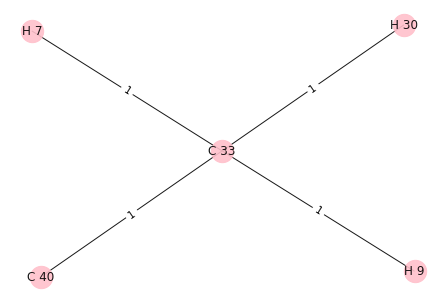

Enter G value of [H 9, H 30, C 33, C 40, H 7]: 100
Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 9, H 30, C 33, C 40, H 7, H 8, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, H 21, C 36, H 18, H 22, H 19, O 45, H 23, O 47, H 24, H 25, H 26, H 27, H 28, H 29, H 31, H 32, C 37, C 38, C 39, O 41, O 42, O 43, O 44, O 46, O 48, N 51, N 52, N 53, N 54, N 55, N 56]
Row: 30
Node1: O 45
Curr val1: 1
Random node choosen: C 33 ; Valency: 0
Random node choosen: C 36 ; Valency: 1
Col: 26
Node2: C 36
Curr val2: 1
1 1
max_num_edges: 1


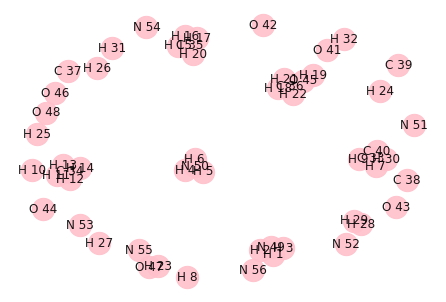

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 9, H 30, C 33, C 40, H 7, H 8, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, O 45, C 36, H 22, H 19, H 21, H 18, H 23, O 47, H 24, H 25, H 26, H 27, H 28, H 29, H 31, H 32, C 37, C 38, C 39, O 41, O 42, O 43, O 44, O 46, O 48, N 51, N 52, N 53, N 54, N 55, N 56]
Row: 52
Node1: N 53
Curr val1: 3
Random node choosen: C 38 ; Valency: 4
Col: 42
Node2: C 38
Curr val2: 4
3 4
max_num_edges: 1


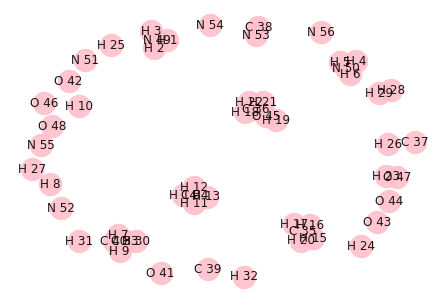

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 9, H 30, C 33, C 40, H 7, H 8, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, O 45, C 36, H 22, H 19, H 21, H 18, H 23, O 47, H 24, H 25, H 26, H 27, H 28, H 29, H 31, H 32, C 37, N 53, C 38, C 39, O 41, O 42, O 43, O 44, O 46, O 48, N 51, N 52, N 54, N 55, N 56]
Row: 45
Node1: O 41
Curr val1: 2
Random node choosen: O 42 ; Valency: 2
Col: 46
Node2: O 42
Curr val2: 2
2 2
max_num_edges: 1


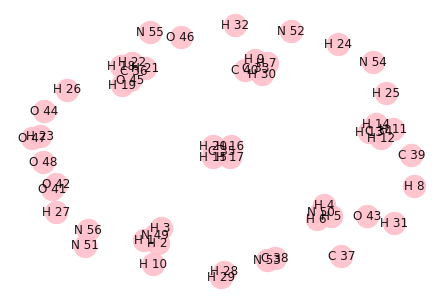

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 9, H 30, C 33, C 40, H 7, H 8, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, O 45, C 36, H 22, H 19, H 21, H 18, H 23, O 47, H 24, H 25, H 26, H 27, H 28, H 29, H 31, H 32, C 37, N 53, C 38, C 39, O 41, O 42, O 43, O 44, O 46, O 48, N 51, N 52, N 54, N 55, N 56]
Row: 41
Node1: C 37
Curr val1: 4
Random node choosen: H 7 ; Valency: 0
Random node choosen: O 42 ; Valency: 1
Col: 46
Node2: O 42
Curr val2: 1
4 1
max_num_edges: 1


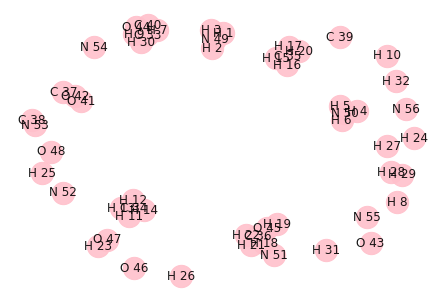

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 9, H 30, C 33, C 40, H 7, H 8, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, O 45, C 36, H 22, H 19, H 21, H 18, H 23, O 47, H 24, H 25, H 26, H 27, H 28, H 29, H 31, H 32, C 37, O 41, O 42, N 53, C 38, C 39, O 43, O 44, O 46, O 48, N 51, N 52, N 54, N 55, N 56]
Row: 11
Node1: C 40
Curr val1: 3


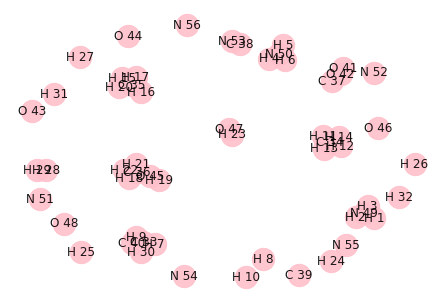

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 9, H 30, C 33, C 40, H 7, H 8, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, O 45, C 36, H 22, H 19, H 21, H 18, H 23, O 47, H 24, H 25, H 26, H 27, H 28, H 29, H 31, H 32, C 37, O 41, O 42, N 53, C 38, C 39, O 43, O 44, O 46, O 48, N 51, N 52, N 54, N 55, N 56]
Row: 40
Node1: H 32
Curr val1: 1


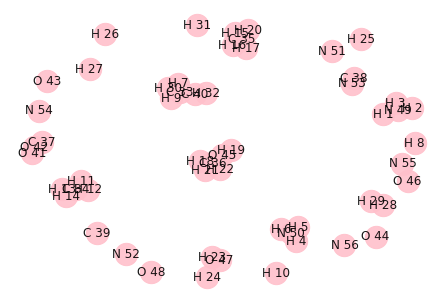

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 9, H 30, C 33, H 32, C 40, H 7, H 8, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, O 45, C 36, H 22, H 19, H 21, H 18, H 23, O 47, H 24, H 25, H 26, H 27, H 28, H 29, H 31, C 37, O 41, O 42, N 53, C 38, C 39, O 43, O 44, O 46, O 48, N 51, N 52, N 54, N 55, N 56]
Row: 40
Node1: H 31
Curr val1: 1
Random node choosen: C 40 ; Valency: 2
Col: 12
Node2: C 40
Curr val2: 2
1 2
max_num_edges: 1


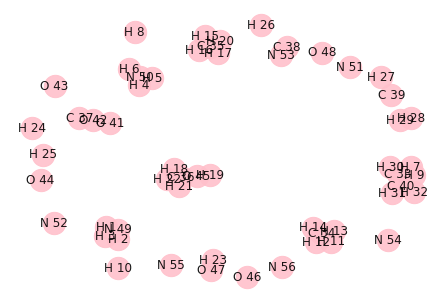

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 8, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, O 45, C 36, H 22, H 19, H 21, H 18, H 23, O 47, H 24, H 25, H 26, H 27, H 28, H 29, C 37, O 41, O 42, N 53, C 38, C 39, O 43, O 44, O 46, O 48, N 51, N 52, N 54, N 55, N 56]
Row: 48
Node1: N 56
Curr val1: 3


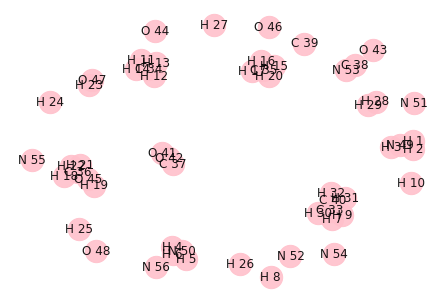

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 8, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, O 45, C 36, H 22, H 19, H 21, H 18, H 23, O 47, H 24, H 25, H 26, H 27, H 28, H 29, C 37, O 41, O 42, N 53, C 38, C 39, O 43, O 44, O 46, O 48, N 51, N 52, N 54, N 55, N 56]
Row: 29
Node1: H 25
Curr val1: 1
Random node choosen: H 12 ; Valency: 0
Random node choosen: H 14 ; Valency: 0
Random node choosen: H 18 ; Valency: 0
Random node choosen: H 4 ; Valency: 0
Random node choosen: N 55 ; Valency: 3
Col: 47
Node2: N 55
Curr val2: 3
1 3
max_num_edges: 1


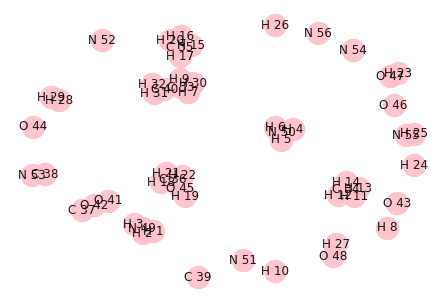

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 8, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, O 45, C 36, H 22, H 19, H 21, H 18, H 23, O 47, H 24, N 55, H 25, H 26, H 27, H 28, H 29, C 37, O 41, O 42, N 53, C 38, C 39, O 43, O 44, O 46, O 48, N 51, N 52, N 54, N 56]
Row: 39
Node1: C 38
Curr val1: 3
Random node choosen: H 15 ; Valency: 0
Random node choosen: N 55 ; Valency: 2
Col: 29
Node2: N 55
Curr val2: 2
3 2
max_num_edges: 2


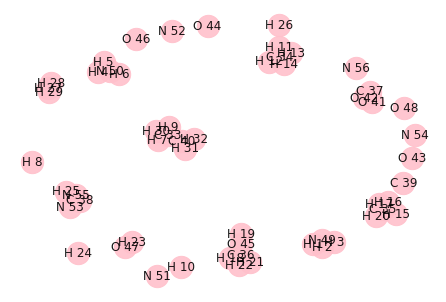

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 8, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, O 45, C 36, H 22, H 19, H 21, H 18, H 23, O 47, H 24, N 55, C 38, H 25, N 53, H 26, H 27, H 28, H 29, C 37, O 41, O 42, C 39, O 43, O 44, O 46, O 48, N 51, N 52, N 54, N 56]
Row: 32
Node1: N 53
Curr val1: 2


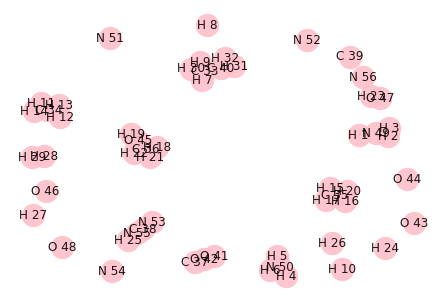

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 8, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, O 45, C 36, H 22, H 19, H 21, H 18, H 23, O 47, H 24, N 55, C 38, H 25, N 53, H 26, H 27, H 28, H 29, C 37, O 41, O 42, C 39, O 43, O 44, O 46, O 48, N 51, N 52, N 54, N 56]
Row: 27
Node1: O 47
Curr val1: 1
Random node choosen: H 8 ; Valency: 1
Col: 8
Node2: H 8
Curr val2: 1
1 1
max_num_edges: 1


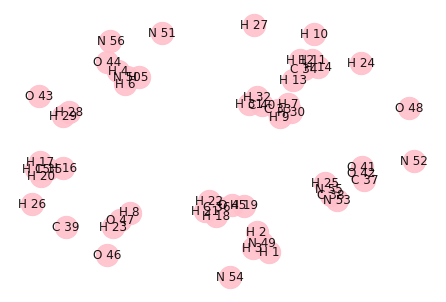

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 8, O 47, H 23, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, O 45, C 36, H 22, H 19, H 21, H 18, H 24, N 55, C 38, H 25, N 53, H 26, H 27, H 28, H 29, C 37, O 41, O 42, C 39, O 43, O 44, O 46, O 48, N 51, N 52, N 54, N 56]
Row: 42
Node1: O 44
Curr val1: 2


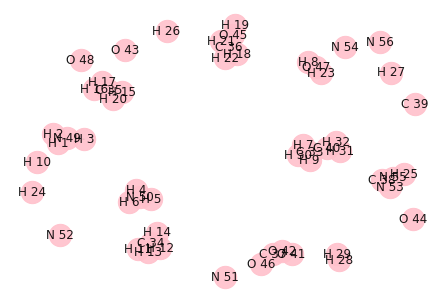

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 8, O 47, H 23, H 10, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, O 45, C 36, H 22, H 19, H 21, H 18, H 24, N 55, C 38, H 25, N 53, H 26, H 27, H 28, H 29, C 37, O 41, O 42, C 39, O 43, O 44, O 46, O 48, N 51, N 52, N 54, N 56]
Row: 33
Node1: H 26
Curr val1: 1
Random node choosen: H 2 ; Valency: 0
Random node choosen: C 36 ; Valency: 0
Random node choosen: C 34 ; Valency: 0
Random node choosen: O 48 ; Valency: 2
Col: 44
Node2: O 48
Curr val2: 2
1 2
max_num_edges: 1


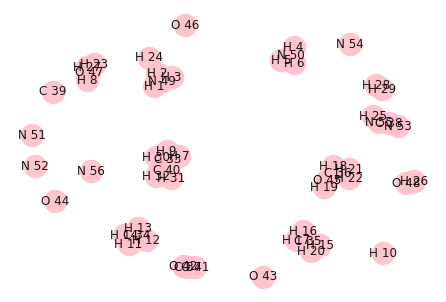

Executed: 14


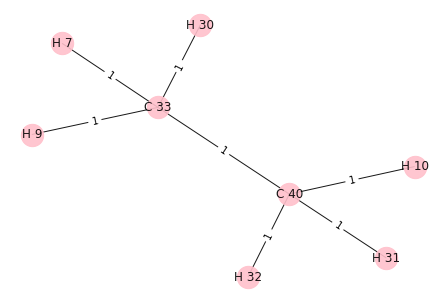

Enter G value of [H 9, H 30, C 33, H 31, H 32, C 40, H 10, H 7]: -257.3456206


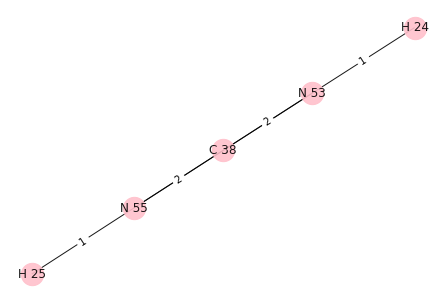

Enter G value of [C 38, N 53, H 24, N 55, H 25]: 100


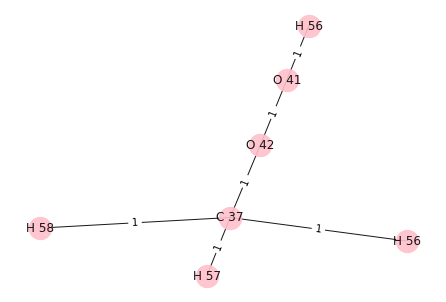

Enter G value of [H 57, H 58, H 56, O 41, O 42, H 56, C 37]: -338.3586447
Executed: 0


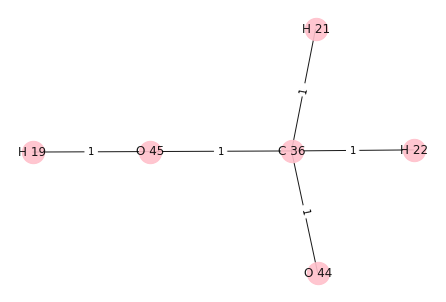

Enter G value of [O 45, C 36, H 19, H 22, H 21, O 44]: -379.0914382


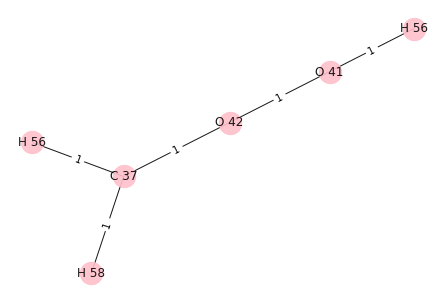

Enter G value of [H 58, H 56, O 41, O 42, H 56, C 37]: -79.0914382
Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 8, O 47, H 23, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, H 18, O 45, C 36, H 19, H 22, H 21, O 44, C 38, N 53, H 24, N 55, H 25, H 27, H 26, O 48, H 28, H 29, H 58, H 56, O 41, O 42, H 56, C 37, H 57, C 39, O 43, O 46, N 51, N 52, N 54, N 56, H 57, H 58]
Row: 50
Node1: N 54
Curr val1: 3
Random node choosen: N 55 ; Valency: 0
Random node choosen: H 27 ; Valency: 0
Random node choosen: N 54 ; Valency: 3
Random node choosen: H 22 ; Valency: 0
Random node choosen: H 6 ; Valency: 0
Random node choosen: N 53 ; Valency: 0
Random node choosen: O 47 ; Valency: 0
Random node choosen: H 26 ; Valency: 0
Random node choosen: O 42 ; Valency: 0
Random node choosen: C 37 ; Valency: 1
Col: 43
Node2: C 37
Curr val2: 1
3 1
max_num_edges: 1


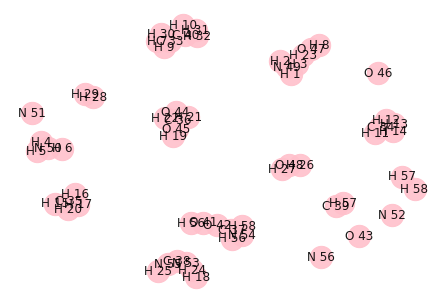

Nodes: [H 1, H 3, N 49, H 2, H 4, N 50, H 5, H 6, H 8, O 47, H 23, H 11, C 34, H 14, H 13, H 12, C 35, H 17, H 15, H 16, H 20, H 18, O 45, C 36, H 19, H 22, H 21, O 44, C 38, N 53, H 24, N 55, H 25, H 27, H 26, O 48, H 28, H 29, H 57, C 39, O 43, O 46, N 51, N 52, N 56, H 57, H 58]
Row: 39
Node1: C 39
Curr val1: 3
Random node choosen: H 57 ; Valency: 0
Random node choosen: H 11 ; Valency: 0
Random node choosen: H 13 ; Valency: 0
Random node choosen: H 1 ; Valency: 0
Random node choosen: H 21 ; Valency: 0
Random node choosen: C 35 ; Valency: 0
Random node choosen: O 47 ; Valency: 0
Random node choosen: C 35 ; Valency: 0
Random node choosen: H 5 ; Valency: 0
Random node choosen: O 45 ; Valency: 0
Random node choosen: H 29 ; Valency: 0
Random node choosen: H 17 ; Valency: 0
Random node choosen: H 2 ; Valency: 0
Random node choosen: H 22 ; Valency: 0
Random node choosen: H 13 ; Valency: 0
Random node choosen: H 25 ; Valency: 0
Random node choosen: H 15 ; Valency: 0
Random node choosen: H 2

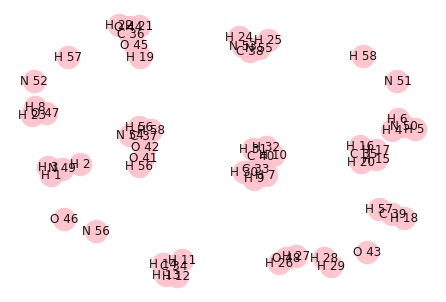

Executed: 2


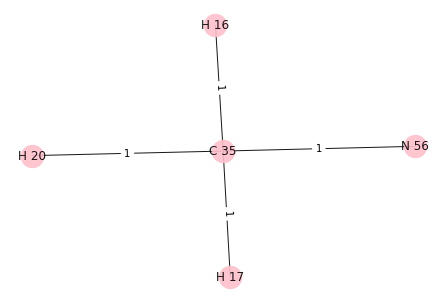

Enter G value of [N 56, C 35, H 17, H 16, H 20]: 100


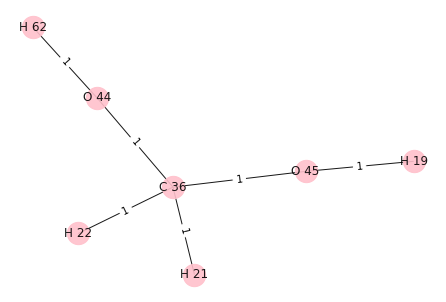

Enter G value of [O 45, C 36, H 62, H 19, H 22, H 21, O 44]: -100


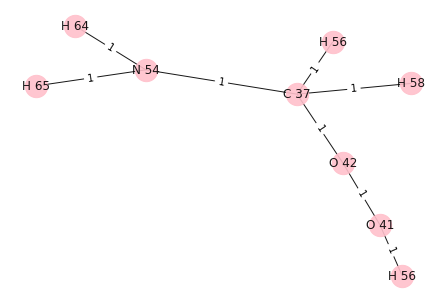

Enter G value of [H 65, H 58, H 56, O 41, N 54, O 42, H 64, H 56, C 37]: -98.34
Executed: 0


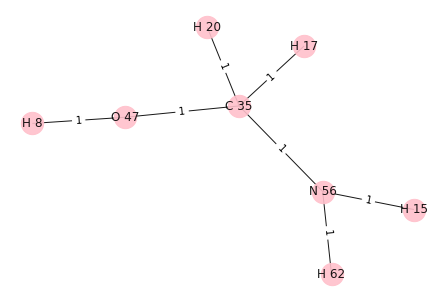

Enter G value of [C 35, N 56, H 17, H 62, O 47, H 15, H 8, H 20]: -13.09751434


In [23]:
#Perform Simulated Annealing over G in multiple cycles.
cycles = 5
T = 10
max_size = 7
for i in range(cycles):
    energy = input_G(G)
    G, energy = simulated_annealing(G, maximum_edges, energy, i, T, max_size)
    T = T*0.995

In [24]:
# connected_components = list(nx.connected_components(G))
# mol1 = G.subgraph(connected_components[0])
# mol2 = G.subgraph(connected_components[1])
# mol3 = G.subgraph(connected_components[2])

# G_new = nx.MultiGraph()
# nodes = []
# edges = {}
# for i in [mol1, mol2, mol3]:
#     nodes.extend(nx.nodes(i))
#     edg_data = nx.get_edge_attributes(i, 'number')
#     for i in edg_data:
#         edges[i] = edg_data[i]

# for i in nodes:
#     G_new.add_nodes_from(nodes)
# for i in edges:
#     for j in range(edges[i]):
#         G_new.add_edge(i[0], i[1])
        
# plot_fig(G_new)

In [25]:
# def form_bonds(G_param, order):
#     M = G_param.copy()
#     M_dict = {}
#     max_size = 8
#     connected_components = list(nx.connected_components(M))
#     n = len(connected_components)
#     while n > 2:
#         if (len(connected_components[0]) + len(connected_components[1])) > max_size:
#             if len(connected_components[0]) >= len(connected_components[1]):
#                 connected_components = connected_components[1:]
#             else:
#                 connected_components.pop(1)
#         else:
#             mol1 = M.subgraph(list(connected_components[0]))
#             mol2 = M.subgraph(list(connected_components[1]))

#             plot_fig(mol1)
#             plot_fig(mol2)

#             H_list1 = [i for i in nx.nodes(mol1) if i._name.split()[0] == "H"]
#             H_list2 = [i for i in nx.nodes(mol2) if i._name.split()[0] == "H"]

#             flag = 1
#             flag1 = 1
#             flag2 = 1
#             if len(H_list1) > 1:
#                 H_to_be_removed1 = H_list1[random.randint(0, len(H_list1)-1)]
#             elif len(H_list1) == 1:
#                 H_to_be_removed1 = H_list1[0]
#             else:
#                 flag1 = 0

#             if len(H_list2) > 1:
#                 H_to_be_removed2 = H_list2[random.randint(0, len(H_list2)-1)]
#             elif len(H_list2) == 1:
#                 H_to_be_removed2 = H_list2[0]
#             else:
#                 flag2 = 0

#             flag = flag1*flag2
#             if flag:
#                 print(H_to_be_removed1)
#                 print(H_to_be_removed2)
#                 neigh1 = [i for i in mol1[H_to_be_removed1]][0]
#                 neigh2 = [i for i in mol2[H_to_be_removed2]][0]

#                 print(neigh1, neigh2)
#                 M.remove_edge(H_to_be_removed1, neigh1)
#                 M.remove_edge(H_to_be_removed2, neigh2)
#                 M.add_edge(neigh1, neigh2)

#                 fix_valencies(M)
#                 plot_fig(M.subgraph(list(nx.node_connected_component(M, neigh1))))
#                 non_H_nodes = []
#                 print(nx.node_connected_component(M, neigh1))
#                 for i in nx.node_connected_component(M, neigh1):
#                     if (i._name.split()[0]!="H"):
#                         non_H_nodes.append(i)
#                 non_H_nodes = list(set(non_H_nodes))

#                 print(non_H_nodes)
#                 for i in range(len(non_H_nodes)):
#                     M_new = M.subgraph(list(nx.node_connected_component(M, neigh1))).copy()
#                     print("i:", i)
#                     temp1 = list(M_new[non_H_nodes[i]].keys())
#                     temp1 = [i for i in temp1 if i._name.split()[0]!="H"][0]
#                     print("Removing edge between:", non_H_nodes[i], temp1)
#                     M_new.remove_edge(non_H_nodes[i], temp1)
#                     print("Adding edge between:", non_H_nodes[i], H_to_be_removed1)
#                     M_new.add_edge(H_to_be_removed1, non_H_nodes[i])
#                     fix_valencies(M_new)
#                     for node in nx.node_connected_component(M_new, H_to_be_removed1):
#                         print(node, node._valency)

#                     plot_fig(M_new.subgraph(nx.node_connected_component(M_new, neigh1)))

#                     for j in non_H_nodes:
#                         print(j._name, j._valency)
#                     second_node = [j for j in non_H_nodes if j._valency!=0]
#                     print(second_node, H_to_be_removed2)
#                     M_new.add_edge(H_to_be_removed2, second_node[0])
#                     fix_valencies(M_new)
#                     plot_fig(M_new.subgraph(nx.node_connected_component(M_new, H_to_be_removed2)))

#                     M_dict[M_new.subgraph(nx.node_connected_component(M_new, neigh1))] = input_G(M_new.subgraph(nx.node_connected_component(M_new, neigh1)))

#                 connected_components = connected_components[2:]
#                 print(connected_components)
#                 n = len(connected_components)
#             else:
#                 connected_components = connected_components[1:]
#                 print(connected_components)
#                 n = len(connected_components)

#     return M_dict
        

In [26]:
# def simulated_annealing_bonds(G, order=[]):
#     connected_components = list(nx.connected_components(G))
#     num_components = len(connected_components)
        
#     # randomly permute the order in which the compounds react
#     if order == []:
#         order = np.random.permutation(num_components)
#     else:
#         order = np.random.permutation(order)
    
#     dict_vals = form_bonds(G, order)
    
#     return dict_vals

In [27]:
# trails = 10
# n = len(list(nx.connected_components(N)))
# final_dict = {}
# order = [i for i in range(n)]
# for i in range(trails):
#     final_dict.update(simulated_annealing_bonds(N, order))

In [28]:
# for i in nx.connected_components(N):
#     print(i)

In [29]:
# new_final = final_dict.copy()
# for i in final_dict:
#     if final_dict[i] > 10:
#         new_final.pop(i)

In [30]:
# len(new_final)

In [31]:
# i = 0
# for compound in new_final:
#     nodes = nx.nodes(compound)
#     plot_fig(compound)
#     if i == 0:
#         essential_compound = compound

In [41]:
# E = nx.MultiGraph(essential_compound)

In [33]:
# M_dict = {}
# max_size = 8
# connected_components = list(nx.connected_components(M))
# n = len(connected_components)
# while n > 2:
#     if (len(connected_components[0]) + len(connected_components[1])) > max_size:
#         if len(connected_components[0]) >= len(connected_components[1]):
#             connected_components = connected_components[1:]
#         else:
#             connected_components.pop(1)
#     else:
#         mol1 = M.subgraph(list(connected_components[0]))
#         mol2 = M.subgraph(list(connected_components[1]))
        
#         plot_fig(mol1)
#         plot_fig(mol2)
        
#         H_list1 = [i for i in nx.nodes(mol1) if i._name.split()[0] == "H"]
#         H_list2 = [i for i in nx.nodes(mol2) if i._name.split()[0] == "H"]
        
#         flag = 1
#         flag1 = 1
#         flag2 = 1
#         if len(H_list1) > 1:
#             H_to_be_removed1 = H_list1[random.randint(0, len(H_list1)-1)]
#         elif len(H_list1) == 1:
#             H_to_be_removed1 = H_list1[0]
#         else:
#             flag1 = 0
        
#         if len(H_list2) > 1:
#             H_to_be_removed2 = H_list2[random.randint(0, len(H_list1)-1)]
#         elif len(H_list2) == 1:
#             H_to_be_removed2 = H_list2[0]
#         else:
#             flag2 = 0
        
#         flag = flag1*flag2
#         if flag:
#             print(H_to_be_removed1)
#             print(H_to_be_removed2)
#             neigh1 = [i for i in mol1[H_to_be_removed1]][0]
#             neigh2 = [i for i in mol2[H_to_be_removed2]][0]

#             print(neigh1, neigh2)
#             M.remove_edge(H_to_be_removed1, neigh1)
#             M.remove_edge(H_to_be_removed2, neigh2)
#             M.add_edge(neigh1, neigh2)

#             fix_valencies(M)
#             plot_fig(M.subgraph(list(nx.node_connected_component(M, neigh1))))
#             non_H_nodes = []
#             print(nx.node_connected_component(M, neigh1))
#             for i in nx.node_connected_component(M, neigh1):
#                 if (i._name.split()[0]!="H"):
#                     non_H_nodes.append(i)
#             non_H_nodes = list(set(non_H_nodes))

#             print(non_H_nodes)
#             for i in range(len(non_H_nodes)):
#                 M_new = M.subgraph(list(nx.node_connected_component(M, neigh1))).copy()
#                 print("i:", i)
#                 temp1 = list(M_new[non_H_nodes[i]].keys())
#                 temp1 = [i for i in temp1 if i._name.split()[0]!="H"][0]
#                 print("Removing edge between:", non_H_nodes[i], temp1)
#                 M_new.remove_edge(non_H_nodes[i], temp1)
#                 print("Adding edge between:", non_H_nodes[i], H_to_be_removed1)
#                 M_new.add_edge(H_to_be_removed1, non_H_nodes[i])
#                 fix_valencies(M_new)
#                 for node in nx.node_connected_component(M_new, H_to_be_removed1):
#                     print(node, node._valency)

#                 plot_fig(M_new.subgraph(nx.node_connected_component(M_new, neigh1)))

#                 for j in non_H_nodes:
#                     print(j._name, j._valency)
#                 second_node = [j for j in non_H_nodes if j._valency!=0]
#                 print(second_node, H_to_be_removed2)
#                 M_new.add_edge(H_to_be_removed2, second_node[0])
#                 fix_valencies(M_new)
#                 plot_fig(M_new.subgraph(nx.node_connected_component(M_new, H_to_be_removed2)))

#                 M_dict[M_new.subgraph(nx.node_connected_component(M_new, neigh1))] = input_G(M_new.subgraph(nx.node_connected_component(M_new, neigh1)))

#             connected_components = connected_components[2:]
#             print(connected_components)
#             n = len(connected_components)
#         else:
#             connected_components = connected_components[1:]
#             print(connected_components)
#             n = len(connected_components)

In [34]:
# for i in M_dict:
#     plot_fig(i, str(M_dict[i]))

In [35]:
# A_list = H_list[0:5]
# B_list = C_list[0:5]
# Z_list = O_list[0:5]
# Y_list = N_list[0:5]

# M = nx.MultiGraph()
# for i,lst in enumerate([A_list, B_list, Z_list, Y_list]):
#     for comp in lst:
#         M.add_node(comp, data=comp)

# for i in nx.nodes(M):
#     i.current_valency(M)

# new_M = generate_random_graphs(M, 15, 2, 3)
# for i in nx.connected_components(new_M):
#     if len(i) > 1:
#         plot_fig(new_M.subgraph(list(i)), "Connected Components of M, max_size=3")
        
# new_M = generate_random_graphs(M, 15, 2, 2)
# for i in nx.connected_components(new_M):
#     if len(i) > 1:
#         plot_fig(new_M.subgraph(list(i)), "Connected Components of M, max_size=2")

In [36]:
# G_new = get_neutral_compound(G)
# plot_fig(G_new, "Graph G_new after charge neutrality")

In [37]:
# cc = list(nx.connected_components(G))
# n = len(cc)
# times = n//2
# print("Old connected components:")
# for i in cc:
#     print(i)
# G_new = rearrange_connected_components(G, cc, n, times)
# cc = list(nx.connected_components(G_new))
# print("New connected components:")
# for i in cc:
#     print(i)

In [38]:
# trails = 10
# G_list = []
# for i in range(trails):
#     G = generate_random_graphs(G, maximum_edges, i,3)
# #     plot_fig(G_list[-1])

# new_G = nx.MultiGraph()

# for i in nx.connected_components(G):
#     if len(i)>1:
#         plot_fig(G.subgraph(list(i)))
#         new_G = nx.compose(new_G,G.subgraph(list(i)))
        
# plot_fig(new_G)

In [39]:
# final_G = nx.MultiGraph()

# H_list = [Compound("H", i) for i in range(1,33)]
# C_list = [Compound("C", i) for i in range(33, 41)]
# O_list = [Compound("O", i) for i in range(41, 49)]
# N_list = [Compound("N", i) for i in range(49, 57)]